In [5]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import sensemakr
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from sspipe import p, px

# Set up paths
main_path = Path().resolve().parents[2] / 'Data' / 'elsa_10' / 'tab'
derived_path = Path().resolve().parents[2] / 'Data' / 'derived_10'
figure_path = Path().resolve().parents[1] / 'output' / 'figure'
table_path = Path().resolve().parents[1] / 'output' / 'table'

# Read data
main_10 = pd.read_csv(derived_path / 'wave_10_pca.csv')

In [2]:
# Get the same sample used in 5_iptw.py
# poorer health leads to lower digital literacy
main_10['SCINNO05'].value_counts(dropna=False)  # NAs due to refused
main_10['SCINNO06'].value_counts(dropna=False)

sample = main_10.loc[(main_10['SCINNO05'] != 1) & (main_10['SCINNO06'] != 1), :]  # N = 3963

# poorer health leads to higher digital literacy
main_10['HeFunc'].value_counts(dropna=False)  # remove respondents with mobility limitation
sample = sample.loc[sample['HeFunc'] != 4, :]  # N = 3822

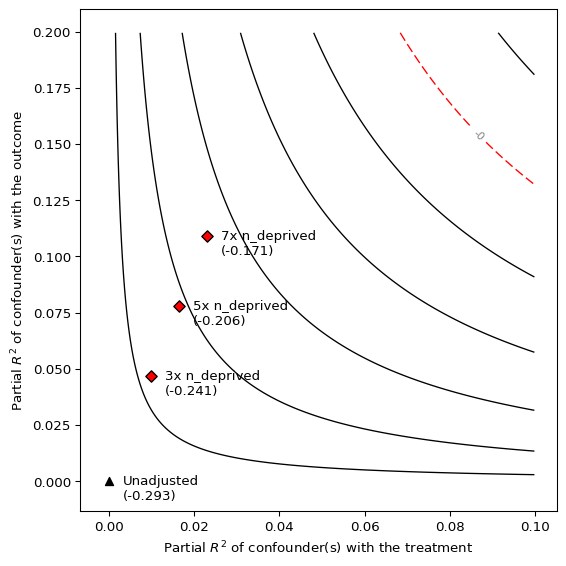

In [4]:
# self-rated health
srh_ols = smf.ols('srh ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                  data=sample).fit()
srh_sense = sensemakr.Sensemakr(model=srh_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                kd=[3, 5, 7])
srh_sense.plot(lim_y=0.20, lim=0.10, label_bump_y=-0.008)

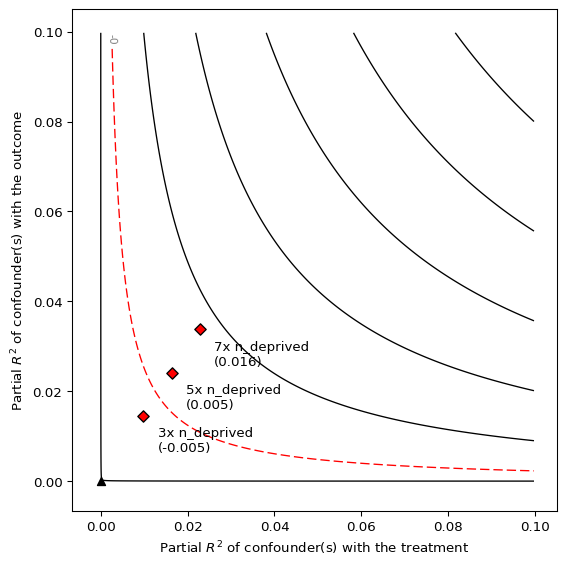

In [7]:
# high cholesterol
high_chol_ols = smf.ols('high_chol ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                        data=sample).fit()
high_chol_sense = sensemakr.Sensemakr(model=high_chol_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                      kd=[3, 5, 7])
high_chol_sense.plot(lim_y=0.10, lim=0.10, label_bump_y=-0.008)

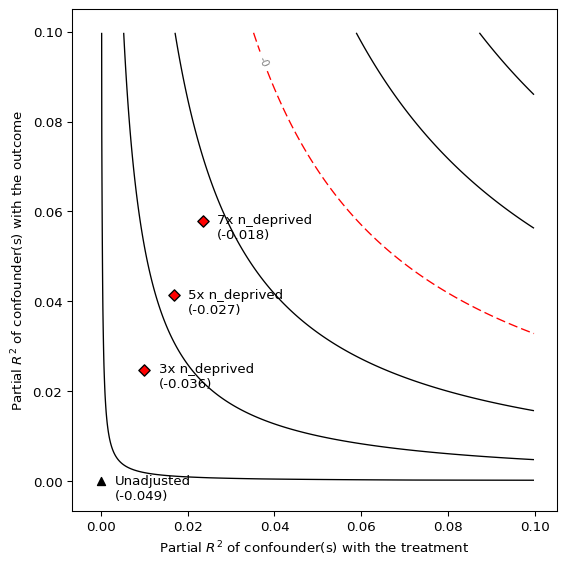

In [6]:
# diabetes
diabetes_ols = smf.ols('diabetes ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                       data=sample).fit()
diabetes_sense = sensemakr.Sensemakr(model=diabetes_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                     kd=[3, 5, 7])
diabetes_sense.plot(lim_y=0.10, lim=0.10, label_bump_y=-0.004)

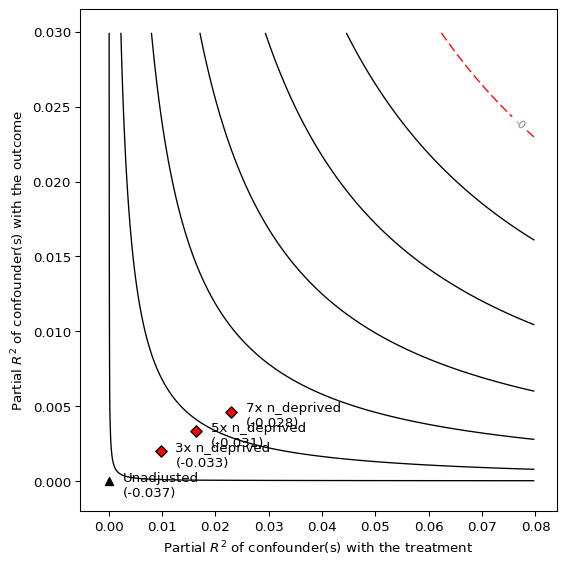

In [15]:
# asthma
asthma_ols = smf.ols('asthma ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                     data=sample).fit()
asthma_sense = sensemakr.Sensemakr(model=asthma_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                   kd=[3, 5, 7])
asthma_sense.plot(lim_y=0.03, lim=0.08, label_bump_y=-0.001)

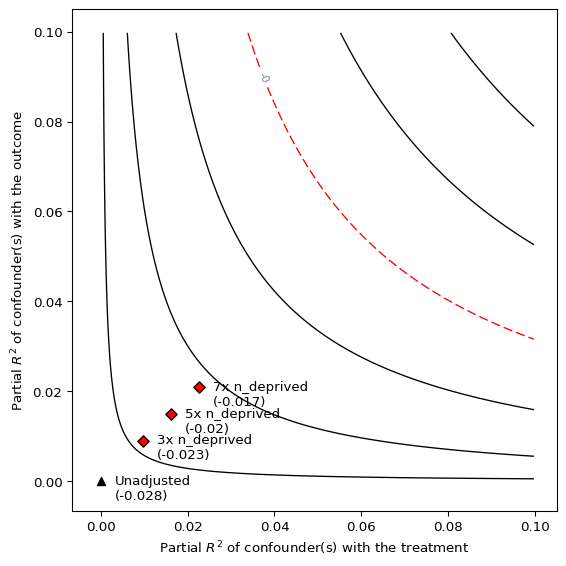

In [16]:
# cancer
cancer_ols = smf.ols('cancer ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                     data=sample).fit()
cancer_sense = sensemakr.Sensemakr(model=cancer_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                     kd=[3, 5, 7])
cancer_sense.plot(lim_y=0.10, lim=0.10, label_bump_y=-0.004)

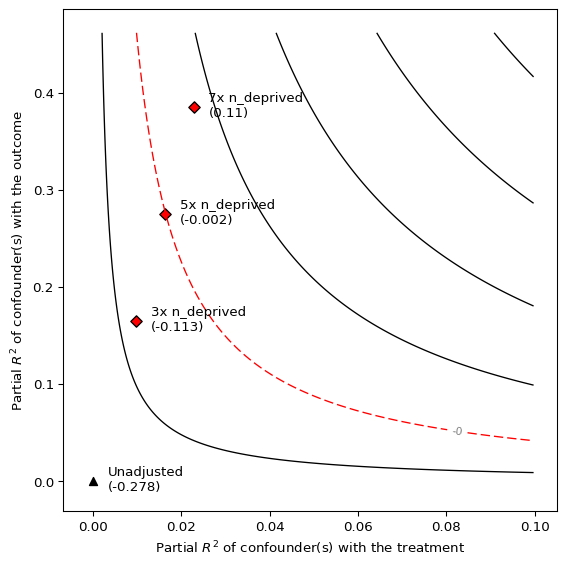

In [8]:
# depression score
cesd_ols = smf.ols('cesd ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                   data=sample).fit()
cesd_sense = sensemakr.Sensemakr(model=cesd_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                 kd=[3, 5, 7])
cesd_sense.plot(lim=0.10, label_bump_y=-0.01)

In [17]:
image_path = [figure_path / 'srh_sense.png', 
              figure_path / 'high_chol_sense.png',
              figure_path / 'diabetes_sense.png', 
              figure_path / 'asthma_sense.png',
              figure_path / 'cancer_sense.png',
              figure_path / 'cesd_sense.png']

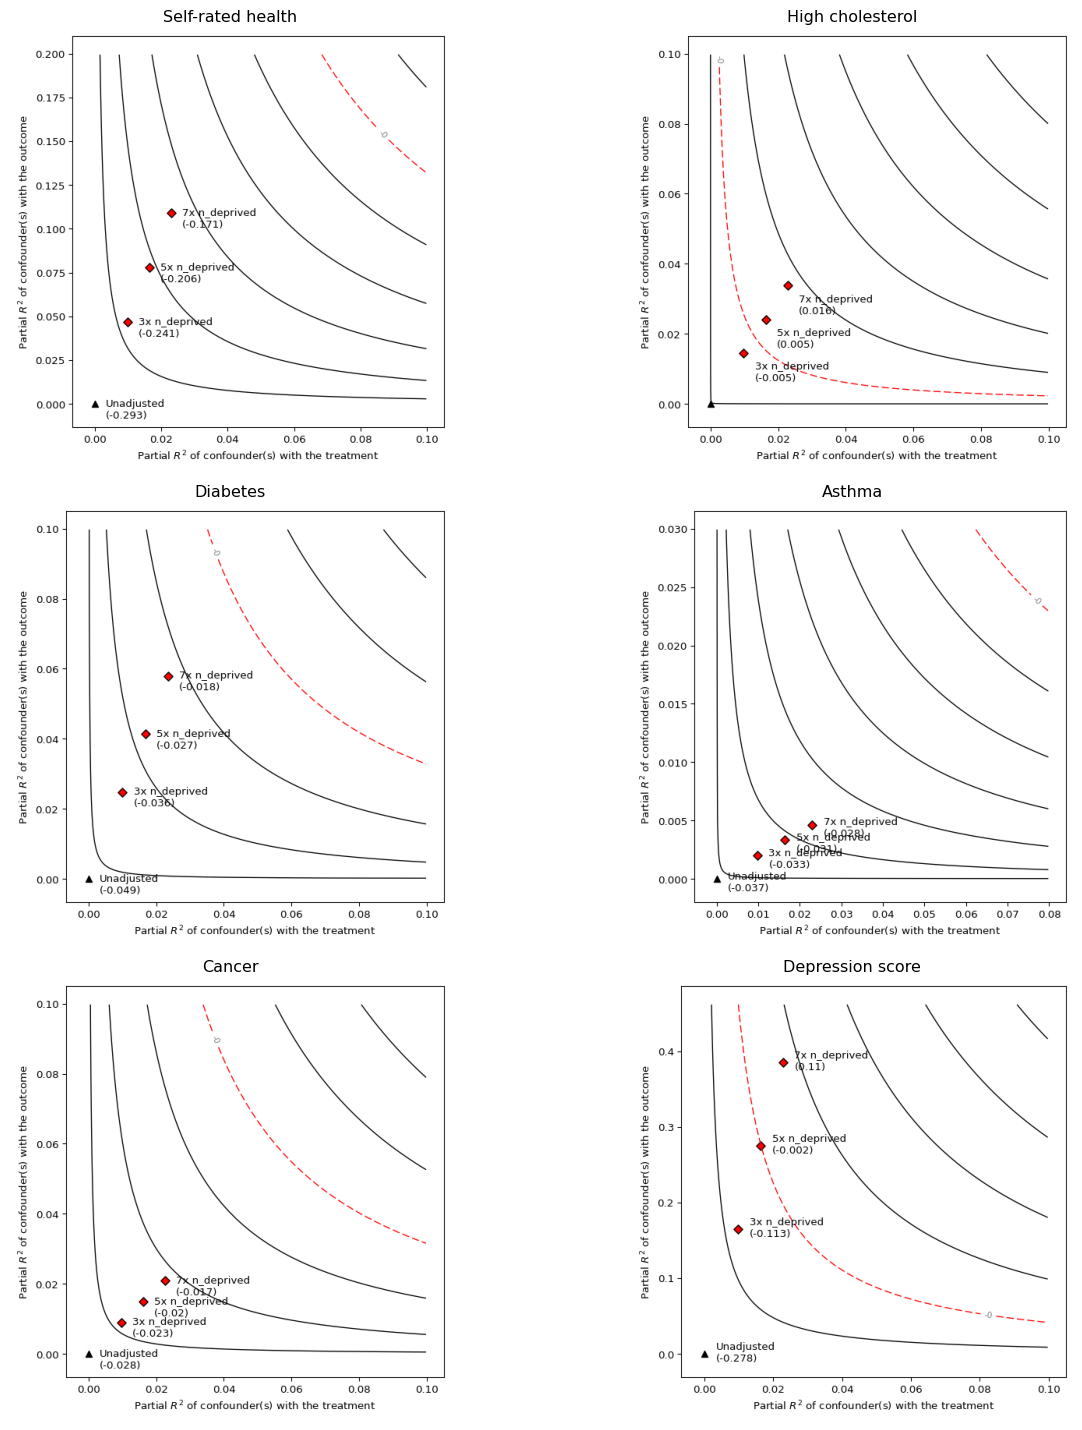

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

titles = ['Self-rated health', 'High cholesterol', 'Diabetes', 'Asthma', 'Cancer', 'Depression score']

for i, ax in enumerate(axs.flat):
    img = Image.open(image_path[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(titles[i])

plt.tight_layout()
plt.savefig(figure_path / 'sensitivity.png', dpi=300)

In [6]:
# Positivity assumption
# calculate the mean of stabilised weights

sample_literacy = sample.dropna(subset=['PC1_b', 'total_income_bu_d', 'age', 'sex', 'ethnicity', 'edu_age', 'edu_qual', 'n_deprived', 'employ_status', 'marital_status', 'memory', 'numeracy', 'comprehension'])
sample_literacy['PC1_b'].value_counts(dropna=False)  # 1: 917, 0: 788

# logit model
logit_ps = smf.logit('PC1_b ~ total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                     data=sample_literacy).fit()
logit_ps.summary()

sample_literacy['ps_literacy'] = logit_ps.predict(sample_literacy)

# stabilised IPTW
sample_literacy['iptw_literacy_s'] = np.select(condlist=[sample_literacy['PC1_b'] == 1, sample_literacy['PC1_b'] == 0],
                                               choicelist=[np.nanmean(sample_literacy['PC1_b']) / sample_literacy[
                                                   'ps_literacy'],
                                                           (1 - np.nanmean(sample_literacy['PC1_b'])) / (
                                                                   1 - sample_literacy['ps_literacy'])],
                                               default=np.nan)

np.nanmean(sample_literacy['iptw_literacy_s']) | p(round, 3)

Optimization terminated successfully.
         Current function value: 0.386744
         Iterations 7


/var/folders/h8/6y3902wx2jl73vcs3ydypw6h0000gn/T/ipykernel_4122/3650899575.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_literacy['ps_literacy'] = logit_ps.predict(sample_literacy)
/var/folders/h8/6y3902wx2jl73vcs3ydypw6h0000gn/T/ipykernel_4122/3650899575.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_literacy['iptw_literacy_s'] = np.select(condlist=[sample_literacy['PC1_b'] == 1, sample_literacy['PC1_b'] == 0],


0.942